<a href="https://colab.research.google.com/github/alik604/cyber-security/blob/master/Anomaly-Detection/S%26P_500_Anomaly_Detection_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

combine N stocks via PCA, autoencoder, averaging the normalized signal 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
!pip install yfinance
import yfinance as yf # https://github.com/ranaroussi/yfinance


from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# spx,nasdaq, ....DJI other indexes 

# SPX = yf.Ticker("INX").history(period='20y')
# QQQ = yf.Ticker("^IXIC").history(period='20y')
# DJI = yf.Ticker("^DJI").history(period='20y')


df = pd.DataFrame({
                  'spx':yf.Ticker("^GSPC").history(period='20y')["Close"]
                  ,'nas':yf.Ticker("^IXIC").history(period='20y')["Close"]
                  ,'dji':yf.Ticker("^DJI").history(period='20y')["Close"]
                  ,'rut':yf.Ticker("^RUT").history(period='20y')["Close"]
                # ,'UKX':yf.Ticker("^FTSE").history(period='20y')["Close"]  # UKX == ^FTSE                 
                          }).dropna()
df.head(10)

#normalized_df=(df-df.mean())/df.std() # mean 
normalized_df=(df-df.min())/(df.max()-df.min()) # min - max 


,spx,nas,dji,rut
Date,,,,
1999-11-04,1362.64,3055.95,10639.64,439.90
1999-11-05,1370.23,3102.29,10704.48,442.41
1999-11-08,1377.01,3143.97,10718.85,445.07
1999-11-09,1365.28,3125.04,10617.32,446.28
1999-11-10,1373.46,3155.96,10597.74,448.72
1999-11-11,1381.46,3197.29,10595.30,447.49
1999-11-12,1396.06,3221.15,10769.32,449.69
1999-11-15,1394.39,3219.54,10760.75,452.97
1999-11-16,1420.07,3295.52,10932.33,456.88


# Data visualization

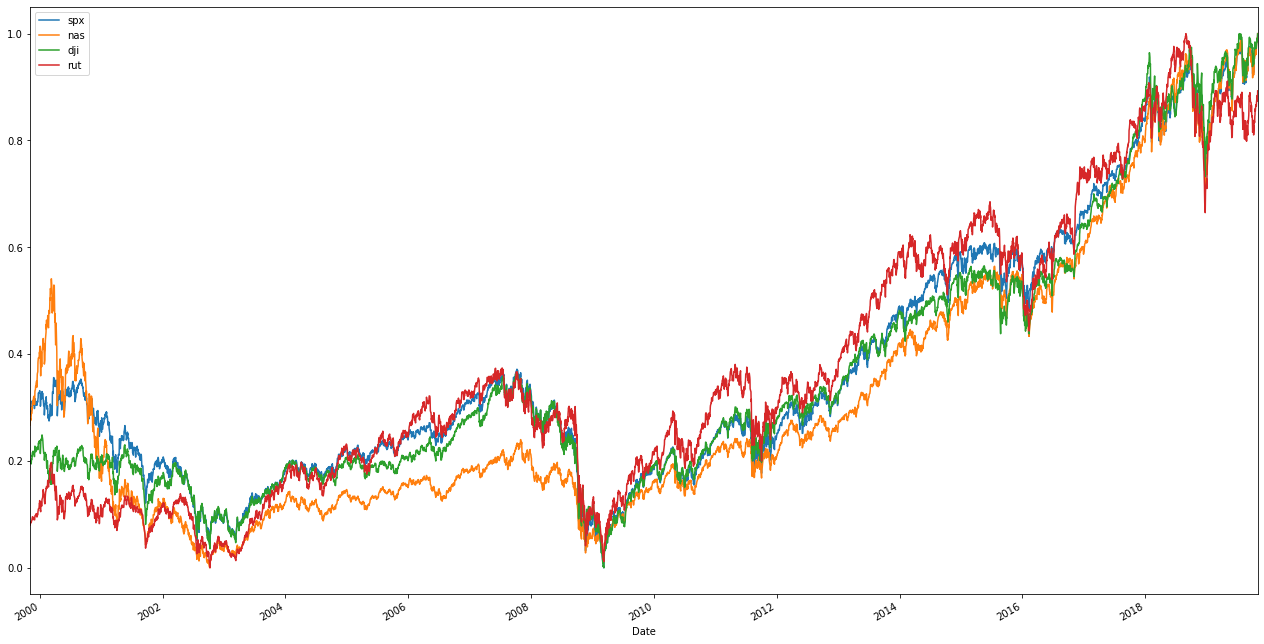

In [ ]:
normalized_df.plot(figsize=(22,12), use_index=True)

In [ ]:
# x= spy.close.values # ndarray 
# X = x.reshape(-1,1)

In [ ]:
def sample_MSE_implementation(df):
    from sklearn.metrics import mean_squared_error
    Matrix = [[round(mean_squared_error(df.iloc[:, row],df.iloc[:, col]),6) for row in range(df.columns.size)] for col in range(df.columns.size)] 
    return pd.DataFrame(Matrix, columns=df.columns, index=df.columns)
sample_MSE_implementation(normalized_df)

,spx,nas,dji,rut
spx,0.000000,0.004892,0.001373,0.004746
nas,0.004892,0.000000,0.004962,0.011061
dji,0.001373,0.004962,0.000000,0.003618
rut,0.004746,0.011061,0.003618,0.000000


In [ ]:
def sample_MAE_implementation(df):
    from sklearn.metrics import mean_absolute_error
    Matrix = [[round(mean_absolute_error(df.iloc[:, row],df.iloc[:, col]),6) for row in range(df.columns.size)] for col in range(df.columns.size)] 
    return pd.DataFrame(Matrix, columns=df.columns, index=df.columns)
sample_MAE_implementation(normalized_df)

,spx,nas,dji,rut
spx,0.000000,0.059710,0.025607,0.050866
nas,0.059710,0.000000,0.055823,0.086914
dji,0.025607,0.055823,0.000000,0.051152
rut,0.050866,0.086914,0.051152,0.000000


In [ ]:
normalized_df.corr()

,spx,nas,dji,rut
spx,1.000000,0.983688,0.990671,0.963580
nas,0.983688,1.000000,0.970720,0.934410
dji,0.990671,0.970720,1.000000,0.974074
rut,0.963580,0.934410,0.974074,1.000000


Data looks very well similar given the
* Mean squared error 
* Mean absolute error
* Correlation (pearson)  

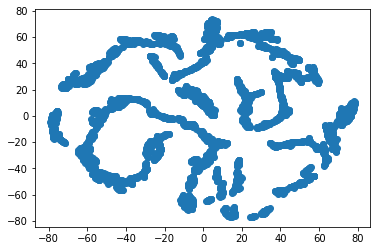

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(normalized_df.values)
plt.scatter(X_embedded[:,0],X_embedded[:,1])

Well that looks useless.... I stand be my current opinion, dimensionality reduction for data visualization of time series is nothing more that self-presuring  

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(normalized_df.values)
X_pca = pca.fit_transform(normalized_df.values)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

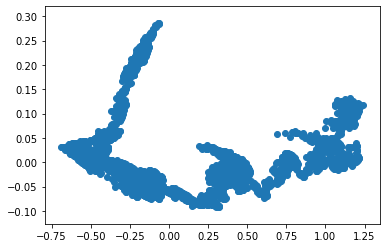

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1],)

In [ ]:
print(pca.components_)


[[ 0.48441197  0.5092927   0.49373335  0.51204821]
 [ 0.18172265  0.64150251 -0.07054895 -0.74193952]]


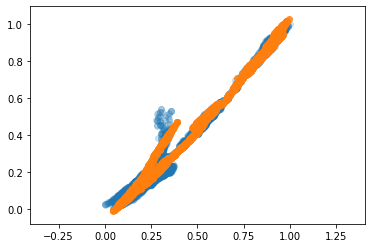

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(normalized_df.values[:, 0], normalized_df.values[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

# let's try reducing Dimentionality with a *Autoencoder* 

In [ ]:
# from https://blog.keras.io/building-autoencoders-in-keras.html
from keras.layers import Input, Dense, BatchNormalization,Conv1D,LSTM,RepeatVector, MaxPooling1D,UpSampling1D
from keras.models import Model

values = normalized_df.values

## Feed Forwards

In [ ]:
# this is the size of our encoded representations
encoding_dim = len(normalized_df.columns) #32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
dim = 2
# this is our input placeholder
input_img = Input(shape=(encoding_dim,))

# "encoded" is the encoded representation of the input
# this model maps an input to its encoded representation
encoded = Dense(dim, activation='relu')(input_img)
encoder = Model(input_img, encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(encoding_dim, activation='sigmoid')(encoded) ## changes pram 1 
autoencoder = Model(input_img, decoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
# from keras.utils import plot_model
# plot_model(autoencoder, show_shapes=True)

In [ ]:
autoencoder.fit(values,values,epochs=5)
yhat = autoencoder.predict(values, verbose=1)

Epoch 1/5
5031/5031 [==============================] - 1s 201us/step - loss: 0.6750
Epoch 2/5
5031/5031 [==============================] - 1s 138us/step - loss: 0.5793
Epoch 3/5
5031/5031 [==============================] - 1s 137us/step - loss: 0.5513
Epoch 4/5
5031/5031 [==============================] - 1s 137us/step - loss: 0.5360
Epoch 5/5
5031/5031 [==============================] - 1s 129us/step - loss: 0.5239


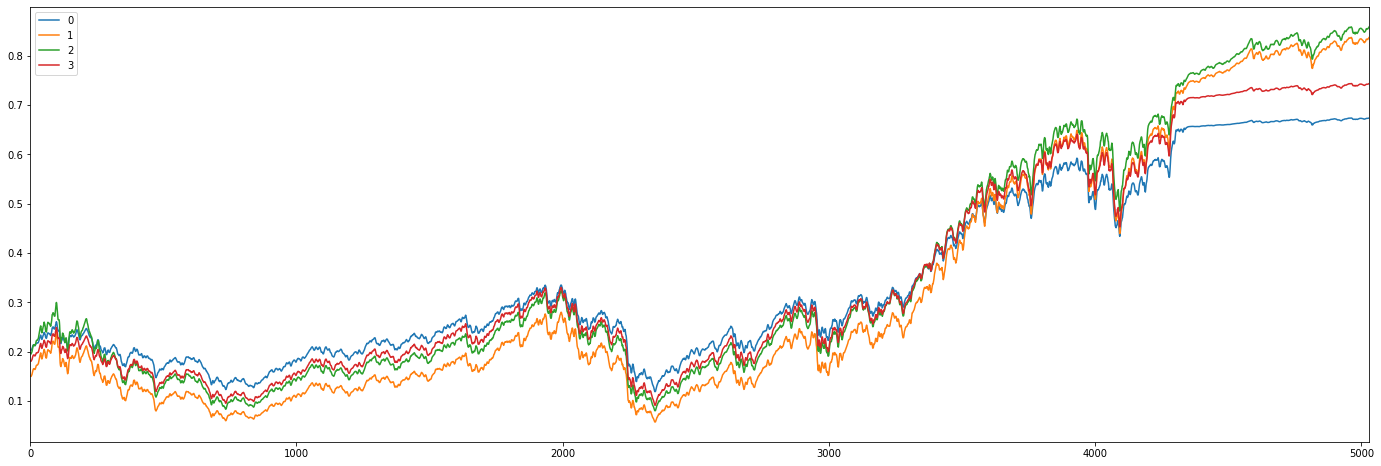

In [ ]:
myDict = {'0':np.transpose(yhat)[0],
'1':np.transpose(yhat)[1],
'2':np.transpose(yhat)[2],
'3':np.transpose(yhat)[3]}

tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(5).mean()
tmp.plot(figsize=(24,8))

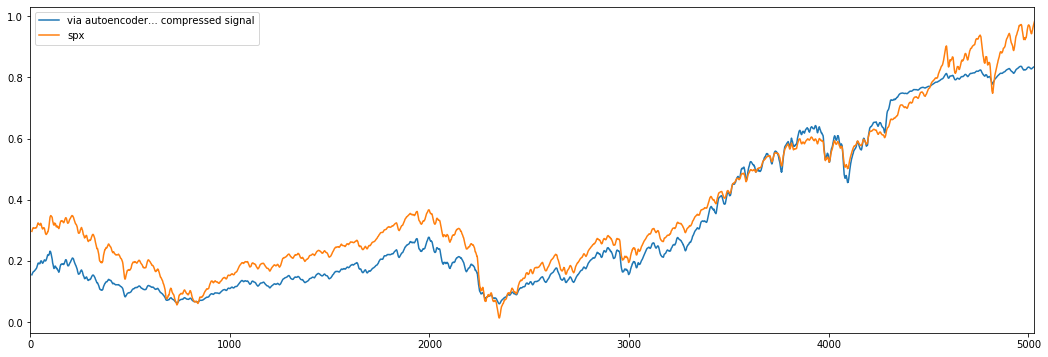

In [ ]:
# myDict = {'via autoencoder... posiable the worng signal':np.transpose(yhat[0]),
#           'spx':normalized_df.spx.values
# }
myDict = {'via autoencoder... compressed signal':np.transpose(yhat)[1],
          'spx':normalized_df.spx.values
}


tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(10).mean()
tmp.plot(figsize=(18,6))

## Deep autoencoder


In [ ]:
import gc
gc.collect()

872

In [ ]:
dim = 2
encoding_dim = len(normalized_df.columns) 
input_window = Input(shape=(encoding_dim,))


# encoded = Dense(3, activation='relu')(input_img)
# encoded = Dense(dim, activation='relu')(input_img)
# encoder = Model(input_img, encoded)
# decoded = Dense(encoding_dim, activation='sigmoid')(encoded) 
# autoencoder = Model(input_img, decoded)
# encoded_input = Input(shape=(dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))
##############################################################################


x = Dense(3, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(2, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(3, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(encoding_dim, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(values, values,
                epochs=12,
                batch_size=1024,
                shuffle=True)


Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_127 (Dense)            (None, 3)                 15        
_________________________________________________________________
batch_normalization_21 (Batc (None, 3)                 12        
_________________________________________________________________
dense_128 (Dense)            (None, 2)                 8         
_________________________________________________________________
dense_129 (Dense)            (None, 3)                 9         
_________________________________________________________________
batch_normalization_22 (Batc (None, 3)                 12        
_________________________________________________________________
dense_130 (Dense)            (None, 4)                 16 

5031/5031 [==============================] - 0s 64us/step


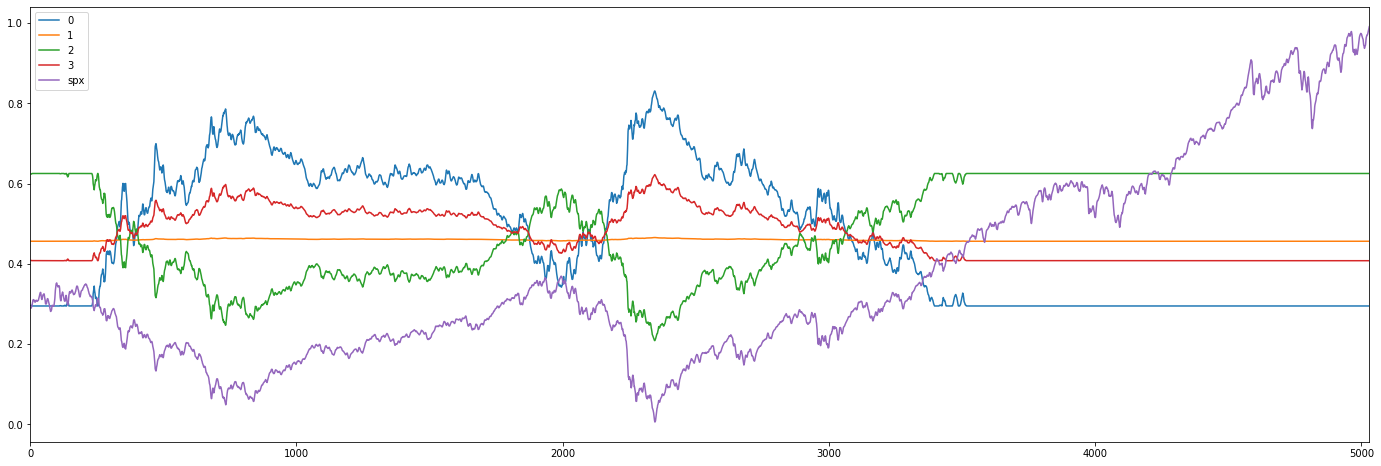

In [ ]:
#autoencoder.fit(values,values,epochs=5)
yhat = autoencoder.predict(values, verbose=1)
myDict = {'0':np.transpose(yhat)[0],
'1':np.transpose(yhat)[1],
'2':np.transpose(yhat)[2],
'3':np.transpose(yhat)[3],
'spx':normalized_df.spx.values}

tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(5).mean()
tmp.plot(figsize=(24,8))

## 1D convolutional autoencoder

In [ ]:
values3=values.reshape(-1,1,1)

inputs = Input(shape=(encoding_dim, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(encoding_dim)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(values3, values3,
                epochs=10,
                batch_size=1024,
                shuffle=True)

decoded_stocks = sequence_autoencoder.predict(values3)

Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       (None, 4, 1)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 96        
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 4, 4)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4, 1)              24        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

In [ ]:
#autoencoder.fit(values,values,epochs=5)
yhat = autoencoder.predict(values, verbose=1)
myDict = {'0':np.transpose(yhat)[0],
'1':np.transpose(yhat)[1],
'2':np.transpose(yhat)[2],
'3':np.transpose(yhat)[3],
'spx':normalized_df.spx.values}

tmp = pd.DataFrame(myDict)
tmp = tmp.rolling(5).mean()
tmp.plot(figsize=(24,8))

In [ ]:
tmp

,0,1,2,3,spx
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,0.296530,0.456348,0.623917,0.408456,0.289993
...,...,...,...,...,...
5026,0.295002,0.456320,0.625204,0.407829,0.978097
5027,0.295002,0.456320,0.625204,0.407829,0.981519
5028,0.295002,0.456320,0.625204,0.407829,0.985054
5029,0.295002,0.456320,0.625204,0.407829,0.987336


array([[[0.28702968]],

       [[0.26701905]],

       [[0.19664465]],

       ...,

       [[1.        ]],

       [[0.99943302]],

       [[0.89289175]]])